#### cycleGAN to transform photo into monet painting

In [2]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()

[print(x) for x in local_device_protos if x.device_type == 'GPU']

2.8.0
name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5730467840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9360110196451621428
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419



[None]

In [1]:
from random import random
import numpy as np
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
import tensorflow.keras as k

# use instance normalization as suggested in paper
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
import matplotlib.pyplot as plt

#### Discriminator. 70x70 patch GAN

In [2]:
# C64-C128-C256-C512
# After last layer, conv to 1-dimension then go through sigmoid
# axis of instancenorm is '-1', ensure features are normalized per feature map

def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_image = k.layers.Input(shape=image_shape)
    
    #C64: 4x4 kernel, strides 2x2
    d = k.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # C128: 4x4 kernel, strides 2x2
    d = k.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d) # first norm then activate
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # C256: 4x4 kernel, strides 2x2
    d = k.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # C512: 4x4 kernel, stride 2x2
    # DIY layer,not in original paper
    d = k.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    
    # second last layer. kernel 4x4, but stride 1x1
    d = k.layers.Conv2D(512, (4,4), strides=(1,1), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = k.layers.Conv2D(1, (4,4), strides=(1,1), padding='same', kernel_initializer=init)(d)
    
    # define model
    model = k.models.Model(in_image, patch_out)
    # compile the model
    # batch size is 1, Adam as opt.
    # loss of D is weighted by 50% of each update. This slows down D's change to G during training
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mse', optimizer=opt, loss_weights=[0.5]) # !!! loss_weights is plural
    return model
    

#### Generator. based on resnet

In [3]:
# residual blocks contain two 3x3 Conv with same number of filters in layers

# to release the gradient vanishing and exploding
def resnet_block(n_filters, input_layer):
    # weight init
    init = RandomNormal(stddev=0.02)
    # first conv layer
    g = k.layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
#     g = k.layers.ReLU()(g)
    g = k.layers.Activation('relu')(g)  # ??? to layers.ReLU. 只有leaky直接调用，其他的用activation调用
    # second conv layer
    g = k.layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    # merge channels with input-layer
    g = k.layers.Concatenate()([g, input_layer])
    return g

In [4]:
# define G model: unet same structure

# c7s1-k: 7x7 Conv -stride 1 -Instancenorm-ReLU -k filters
# dk: 3x3 conv -stride 2 -Instancenorm-ReLU -k filters
# Rk: residual block that contains two 3x3 conv layers
# uk: 3x3 fractional~strided~conv -stride 1/2 -Instancenorm -ReLU -k filters

# two possible structures:
# with 6 res-blocks: c7s1-64, d128, d256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1-3
# with 9 res-blocks: c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128, u64,c7s1-3

def define_generator(image_shape, n_resnet=9):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = k.layers.Input(shape=image_shape)
    
    # c7s1-64
    g = k.layers.Conv2D(64, (7,7), strides=(1,1), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    # d128
    g = k.layers.Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    # d256
    g = k.layers.Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(256, g)  # !!! generate the resnet
    # u128
    g = k.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    # u64
    g = k.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    # c7s1-3
    g = k.layers.Conv2D(3, (7,7), strides=(1,1), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = k.layers.Activation('tanh')(g)
    # define the model
    model = k.models.Model(in_image, out_image)  # generator does not compile
    return model

In [5]:
# define a composite model to update generator wuth adversarial and cycle loss
# only use to train generator
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    # use this to train both generators. But one at a time
    # trained G is tranable, others are constant
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    
    # adversarial loss
    input_gen = k.layers.Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    ouput_d = d_model(gen1_out)
    # identity loss
    input_id = k.layers.Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # cycle-loss forward
    output_f = g_model_2(gen1_out)
    # cycle-loss backward
    gen2_out = g_model_2(input_id)  # ???
    output_b = g_model_1(gen2_out)
    
    # define the model graph
    model = k.models.Model([input_gen, input_id], [ouput_d, output_id, output_f, output_b])
    
    # compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1,5,10,10], optimizer=opt) # hyper param from paper
    return model


#### processing images

In [6]:
# load and prepare traning images
def load_real_samples(filename):
    # load the dataset
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1-127.5)/127.5
    X2 = (X2-127.5)/127.5
    return [X1, X2]

# D needs fake and real images
# select batch of samples, return images and target.
# real images the label is '1'
def generate_real_samples(dataset, n_samples, patch_shape):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    # generate the 'real' class label
    y = np.ones((n_samples, patch_shape, patch_shape, 1)) # in th same size of one channel
    return X, y

# fake images with label '0'
def generate_fake_samples(g_model, dataset, patch_shape):
    X = g_model.predict(dataset)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

# save model
def save_models(step, g_model_AtoB, g_model_BtoA):
    # save the first generator models
    filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save(filename1)
    # save the second generator model
    filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))  

In [19]:
# predict images with save model, plot input and output images
def summarize_performance(step, g_model, trainX, name, n_samples=5):
    # sample input images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    # generate translated images
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    # scale pixels from [-1,1] to [0,1]
    X_in = (X_in + 1)/2
    X_out = (X_out + 1)/2
    # plot real images
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1+i)
        plt.axis('off')
        plt.imshow(X_in[i])
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1+i+n_samples)
        plt.axis('off')
        plt.imshow(X_out[i])
    # save plot
    filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
    plt.savefig(filename1)
    plt.close()
        

In [8]:
# update fake images pool to avoid model oscillation
# update D using a history of generated images rather than latest generators
# image buffer is 50

def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            # use images, but don't add it into pool
            selected.append(image)
        else:
            # replace exiting images and use replaced 
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    out = np.asarray(selected)  # transfer into array
    return out

#### training process

In [9]:
# train cyclegan
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1):
    # training hyper param
    n_epochs, n_batch = epochs, 1 # batch_size is fixed into 1
    # output square shape of D
    n_patch = d_model_A.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # image pool for fake images
    poolA, poolB = list(), list()
    # number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # training iterations
    n_steps = bat_per_epo * n_epochs
    
    # enumerate epochs
    for i in range(n_steps):
        # for every iteration/ batch
        # sample real images from both domain
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        
        # generate fake images for both (A2B, B2A)
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        # update the fake images in the pool as buffer with 50 images
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        
        # update G-B2A via composite model
        # this is the combine model: G1 + G2 + D
        g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        # update D for A->[real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)  # since batch is 1, cannot split into half for real/fale
        
        # update G-A2B via composite model
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        
        # summarize the performance
        # batch size is 1, iteration is same as dataset
        # if there are 100 images, then 1 epoch will be 100 iterations
        print('Iterations>%d, dA[%.3f, %3.f] dB[%.3f,%.3f] g[%.3f, %.3f]'% (i+1, dA_loss1, dA_loss2, dB_loss1, dB_loss2, g_loss1, g_loss2))
        
        # evaluate performance periodically
        if (i+1) % (bat_per_epo * 1) == 0:
            # plot A->B translation
            summarize_performance(i, g_model_AtoB, trainA, 'A2B')
            # plot B->A translation
            summarize_performance(i, g_model_BtoA, trainB, 'B2A')
        
        # save model every 5 batches
        if (i+1) % (bat_per_epo * 5) == 0:
            # if batch size(total images)=100, model saved after every 75th * 5 = 375 iter 
            save_models(i, g_model_AtoB, g_model_BtoA)
            

#### main function part

In [10]:
from os import listdir
from keras.preprocessing.image import img_to_array, load_img

In [11]:
# load all images
def load_images(path, size=(256, 256)):
    data_list = list()
    # enumerate filenames. assume all are images
    for filename in listdir(path):
        # load and resize the images
        pixels = load_img(path + filename, target_size=size)
        # convert into numpy array
        pixels = img_to_array(pixels)
        data_list.append(pixels)
    dataset = np.asarray(data_list)  # convert list into array
    return dataset

In [12]:
# dataset path
path = 'F:/tuorial/python_for_microscopists-master/253-dataset/monet2photo/'

In [13]:
# load data from domain A (monet painting) and preprocess into subset
from sklearn.utils import resample

dataA_all = load_images(path + 'trainA/')
print('Loaded dataA: ', dataA_all.shape)

# get subset of the images
dataA = resample(dataA_all, replace=False, n_samples=500, random_state=42)

print('dataset A: ', dataA.shape)

Loaded dataA:  (1072, 256, 256, 3)
dataset A:  (500, 256, 256, 3)


In [14]:
# load domain B (photo)

dataB_all = load_images(path + 'trainB/')
print('Loaded dataB: ', dataB_all.shape)

# subset
dataB = resample(dataB_all, replace=False, n_samples=500, random_state=42)

Loaded dataB:  (6287, 256, 256, 3)


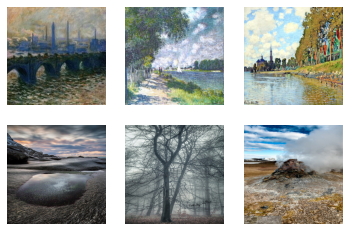

In [15]:
# sanity check
n_samples = 3

for i in range(n_samples):
    plt.subplot(2, n_samples, i+1)
    plt.axis('off')
    plt.imshow(dataA[i].astype('uint8'))
    
for i in range(n_samples):
    plt.subplot(2, n_samples, i+1+n_samples)
    plt.axis('off')
    plt.imshow(dataB[i].astype('uint8'))
plt.show()

In [16]:
# load image data
data = [dataA, dataB]

print('Loaded: ', data[0].shape, data[1].shape)

# scale into [-1, 1]
def preprocess_data(data):
    # unpack arrays
    X1, X2 = data[0], data[1]
    X1 = (X1 - 127.5)/ 127.5
    X2 = (X2 - 127.5)/ 127.5
    return [X1, X2]

dataset = preprocess_data(data)

Loaded:  (500, 256, 256, 3) (500, 256, 256, 3)


In [17]:
# define hyper param and intance of model in cycleGAN
image_shape = data[0].shape[1:]
# generator A->B
g_model_AtoB = define_generator(image_shape)
# generator B->A
g_model_BtoA = define_generator(image_shape)
# D: A-> [real/ fake]
d_model_A = define_discriminator(image_shape)
# D: B-> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A->B->[real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B->A->[real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)


E:\INSTALL\anaconda\envs\seg\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
# training

from datetime import datetime
start1 = datetime.now()
# train model
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=2)

stop1 = datetime.now()


Iterations>1, dA[0.120,   0] dB[0.189,0.142] g[5.193, 4.758]
Iterations>2, dA[0.146,   0] dB[0.031,0.052] g[6.822, 7.677]
Iterations>3, dA[0.168,   0] dB[0.312,0.067] g[6.076, 5.891]
Iterations>4, dA[0.086,   0] dB[0.045,0.124] g[4.632, 5.661]
Iterations>5, dA[0.209,   0] dB[0.238,0.308] g[5.592, 5.938]
Iterations>6, dA[0.040,   0] dB[0.061,0.129] g[8.995, 10.606]
Iterations>7, dA[0.209,   0] dB[0.024,0.068] g[7.950, 8.914]
Iterations>8, dA[0.049,   0] dB[0.041,0.034] g[11.051, 11.005]
Iterations>9, dA[0.197,   0] dB[0.338,0.071] g[7.287, 6.575]
Iterations>10, dA[0.107,   0] dB[0.197,0.236] g[6.364, 6.668]
Iterations>11, dA[0.062,   0] dB[0.280,0.246] g[5.000, 6.012]
Iterations>12, dA[0.172,   0] dB[0.023,0.107] g[10.116, 10.920]
Iterations>13, dA[0.134,   0] dB[0.444,0.148] g[6.555, 6.802]
Iterations>14, dA[0.100,   0] dB[0.161,0.206] g[5.493, 6.146]
Iterations>15, dA[0.118,   0] dB[0.111,0.094] g[5.107, 5.247]
Iterations>16, dA[0.125,   0] dB[0.011,0.095] g[11.899, 11.936]
Iterations

In [22]:
# execustion time
execution_time = stop1 - start1
print('Executed time: ', execution_time)

Executed time:  0:22:49.664918


#### load trained model

In [23]:
# use the saved cycleGAN for image translation
from keras.models import load_model

In [ ]:
# select random samples from dataset
def select_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    return X

In [ ]:
# plot the image, translation and reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
    images = np.vstack((imagesX, imagesY1, imagesY2))
    titles = ['Real', 'Generated', 'Reconstructed']
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    # plot the images
    for i in range(len(images)):
        plt.subplot(1, len(images), 1+i)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(titles[i])
    plt.show()
    

In [ ]:
# load dataset
A_data = resample(dataA_all, replace=False, n_samples=50, random_state=42)
B_data = resample(dataB_all, replace=False, n_samples=50, random_state=42)

A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5

In [ ]:
# load models
cust = {'InstanceNormalization': InstanceNormalization}  # !!! the lcoal normalization 
model_AtoB = load_model('g_model_AtoB_005935.h5', cust)
model_BtoA = load_model('g_model_BtoA_005935.h5', cust)

In [ ]:
# generate the results
# plot A->B->A (Monet to photo to Monet)
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# plot B->A->B (Photo to Monet to Photo)
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)


#### use the custom single image

In [ ]:
test_image = load_img('sunset256.jpg')
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5

# plot B->A->B (Photo to Monet to Photo)
monet_generated  = model_BtoA.predict(test_image_input)
photo_reconstructed = model_AtoB.predict(monet_generated)
show_plot(test_image_input, monet_generated, photo_reconstructed)